# Audio signal pre-processing

Audio signal data will be converted into time domain features and frequency domain features

In [1]:
import os
import math
import random
import librosa
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, Sequential, optimizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (LSTM, Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)

2024-06-05 22:10:47.016702: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 22:10:47.018146: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 22:10:47.043148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 22:10:47.043184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 22:10:47.044149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# DATASET_PATH = "datasets/final_final"
DATASET_PATH = "datasets/noise_reduced"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

# After analysis. These are the best parameters working best for our audio classes
MFCC_NUM = 15
FFT_NUM = 4096
HOP_LENGTH = 4096
SEGMENTS_NUM = 10

category_labelling_map = {
  "Ambulance": 0,
  "Bird": 1,
  "Engine": 2,
  "Explosion": 3,
  "Fire-and-trucks": 4,
  "Human": 5,
  "Police": 6,
  "Rail-transport": 7,
  "Train-horn": 8,
  "Vehicle": 9,
}

## Mel-Spectogram feature extraction on each frame of audio chunks

In [3]:
types = {
  "spectogram": {"key": "spectogram", "func": librosa.feature.melspectrogram},
  # "spectogram_db": {"key": "spectogram_db", "func": librosa.feature.melspectrogram},
  "mfcc": {"key": "mfcc", "func": librosa.feature.mfcc}
}

def get_mfcc_spectogram(_path, _type, sr=SAMPLE_RATE, fft=FFT_NUM, hl=HOP_LENGTH):
  features = {
    "category": [],
    "labels": [],
    "data": []
  }
  
  samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
  num_per_segment = math.ceil(samples_per_segment / hl)
  
  for i, f in enumerate(os.listdir(_path)):
    file_path = os.path.join(_path, f)
    signal, sample_rate = librosa.load(file_path, sr=sr)
  
    # number of segments based on duration
    num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1
  
    category = f.split("_")[0]
    features["category"].append(category)
  
    for d in range(num_segments):
      start = samples_per_segment * d
      finish = start + samples_per_segment

      _data = types[_type]["func"](y=signal[start:finish],
                                  sr=sample_rate, n_fft=fft,
                                  hop_length=hl)
      if _type == "spectogram_db":
        _data = librosa.power_to_db(_data)
      
      _data = _data.T

      # store feature only with expected number of vectors
      if len(_data) == num_per_segment:
        features["data"].append(_data.tolist())
        features["labels"].append(category_labelling_map[category])
  return features

In [4]:
spectogram_feature = get_mfcc_spectogram(DATASET_PATH, types["spectogram"]["key"])
# spectogram_db_feature = get_mfcc_spectogram(DATASET_PATH, types["spectogram_db"]["key"])
mfcc_feature = get_mfcc_spectogram(DATASET_PATH, types["mfcc"]["key"])

In [5]:
def find_category(value):
  for key, val in category_labelling_map.items():
      if val == value:
          return key
  raise "Error: Not found this value"

unique_elements, counts = np.unique(mfcc_feature["labels"], return_counts=True)

for element, count in zip(unique_elements, counts):
  print(f"{find_category(element)} entries -> {count}")

Ambulance entries -> 50
Bird entries -> 50
Engine entries -> 50
Explosion entries -> 50
Fire-and-trucks entries -> 50
Human entries -> 50
Police entries -> 50
Rail-transport entries -> 50
Train-horn entries -> 50
Vehicle entries -> 50


# MFCC feature extraction on each frame of audio chunks

## Algorithms consideration:
- SVM
- Logistic Regression
- Decision Tree
- Convolutional Neural Network
- LSTM

In [12]:
def get_train_test(_feature, _type, is_norm=False):
  if is_norm:
    X = np.array(_feature["data_norm"])
  else:
    X = np.array(_feature["data"])
  y = np.array(_feature["labels"])
  print(f"{_type} {X.shape=}") # number of samples, frames per sample, features in each frame
  
  # if neural:
  X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)

  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]
  
  print(f"{_type} {X_train.shape=}")
  
  return (X_train, X_test, y_train, y_test)
  # else:
  #   # Reshape X to 2D array where each row represents a sample and each column represents a feature
  #   samples, frames, ft_per_frame = X.shape
  #   X_reshaped = X.reshape(samples, -1)
  #   
  #   print(f"{_type} {X_reshaped.shape=}")
    
    # return train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [13]:
X_train_1_mfcc, X_test_1_mfcc, y_train_1_mfcc, y_test_1_mfcc = get_train_test(
  mfcc_feature, types["mfcc"]["key"])

X_train_1_spect, X_test_1_spect, y_train_1_spect, y_test_1_spect = get_train_test(
  spectogram_feature, types["spectogram"]["key"])

# X_train_1_spect_db, X_test_1_spect_db, y_train_1_spect_db, y_test_1_spect_db = get_train_test(
#   spectogram_feature, types["spectogram_db"]["key"])

mfcc X.shape=(500, 17, 20)
mfcc X_train.shape=(400, 17, 20, 1)
spectogram X.shape=(500, 17, 128)
spectogram X_train.shape=(400, 17, 128, 1)


In [14]:
all_spectrograms = np.array(spectogram_feature["data"])
mean = np.mean(all_spectrograms)
std = np.std(all_spectrograms)
mean, std

(18.97729374128882, 223.52055677549444)

In [15]:
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = get_train_test(
  mfcc_feature, types["mfcc"]["key"], False)

X_train_spect, X_test_spect, y_train_spect, y_test_spect = get_train_test(
  spectogram_feature, types["spectogram"]["key"], False)

mfcc X.shape=(500, 17, 20)
mfcc X_train.shape=(400, 17, 20, 1)
spectogram X.shape=(500, 17, 128)
spectogram X_train.shape=(400, 17, 128, 1)


In [23]:
def _CNN_model_compile(_X_train):
  _cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=_X_train.shape[1:]),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    # flatten output
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # output
    Dense(len(category_labelling_map), activation='softmax')
  ])
  
  return _cnn

def _NN_(_model, _X_train, _X_test, _y_train, _y_test, _epochs=100):
  _history = _model.fit(_X_train, _y_train,
                        validation_data=(_X_test, _y_test),
                        batch_size=64, epochs=_epochs)
  return _history

In [24]:
def _print_loss_accuracy(_model, _X_test, _y_test):
  _loss, _accuracy = _model.evaluate(_X_test, _y_test, verbose=2)
  print(f'Loss: {_loss}, Accuracy: {_accuracy}')

In [25]:
# Mel Spectogram
cnn_spect = _CNN_model_compile(X_train_spect)
cnn_spect.compile(optimizer=Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
cnn_spect.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 63, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 8, 63, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 3, 31, 64)         0         
 g2D)                                                            
                                                      

In [26]:
cnn_history_spect = _NN_(cnn_spect, X_train_spect, X_test_spect, y_train_spect, y_test_spect, 300)

Epoch 1/300
7/7 [==============================] - 1s 38ms/step - loss: 2.6718 - accuracy: 0.0950 - val_loss: 3.8789 - val_accuracy: 0.0800
Epoch 2/300
7/7 [==============================] - 0s 24ms/step - loss: 2.5912 - accuracy: 0.1225 - val_loss: 3.0001 - val_accuracy: 0.1100
Epoch 3/300
7/7 [==============================] - 0s 24ms/step - loss: 2.3706 - accuracy: 0.1375 - val_loss: 2.6678 - val_accuracy: 0.1000
Epoch 4/300
7/7 [==============================] - 0s 25ms/step - loss: 2.2953 - accuracy: 0.1575 - val_loss: 2.4788 - val_accuracy: 0.1600
Epoch 5/300
7/7 [==============================] - 0s 25ms/step - loss: 2.2104 - accuracy: 0.2200 - val_loss: 2.3560 - val_accuracy: 0.1600
Epoch 6/300
7/7 [==============================] - 0s 24ms/step - loss: 2.2038 - accuracy: 0.1875 - val_loss: 2.2722 - val_accuracy: 0.2000
Epoch 7/300
7/7 [==============================] - 0s 24ms/step - loss: 2.1539 - accuracy: 0.2525 - val_loss: 2.2119 - val_accuracy: 0.2100
Epoch 8/300
7/7 [===

In [27]:
_print_loss_accuracy(cnn_spect, X_test_spect, y_test_spect)

4/4 - 0s - loss: 1.6949 - accuracy: 0.4800 - 38ms/epoch - 10ms/step
Loss: 1.6949265003204346, Accuracy: 0.47999998927116394


In [28]:
# Mel-Frequency Cepstral Coefficients
cnn_mfcc = _CNN_model_compile(X_train_mfcc)
cnn_mfcc.compile(optimizer=Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
cnn_mfcc.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 15, 18, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 9, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 8, 9, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 3, 4, 64)          0         
 ng2D)                                                           
                                                      

In [29]:
cnn_history_mfcc = _NN_(cnn_mfcc, X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, 300)

Epoch 1/300
7/7 [==============================] - 1s 30ms/step - loss: 3.3276 - accuracy: 0.0825 - val_loss: 2.9793 - val_accuracy: 0.0900
Epoch 2/300
7/7 [==============================] - 0s 12ms/step - loss: 2.9641 - accuracy: 0.1250 - val_loss: 2.6757 - val_accuracy: 0.1400
Epoch 3/300
7/7 [==============================] - 0s 13ms/step - loss: 2.8025 - accuracy: 0.1500 - val_loss: 2.5432 - val_accuracy: 0.1400
Epoch 4/300
7/7 [==============================] - 0s 14ms/step - loss: 2.6151 - accuracy: 0.1800 - val_loss: 2.4664 - val_accuracy: 0.1500
Epoch 5/300
7/7 [==============================] - 0s 14ms/step - loss: 2.4711 - accuracy: 0.1975 - val_loss: 2.4147 - val_accuracy: 0.1400
Epoch 6/300
7/7 [==============================] - 0s 14ms/step - loss: 2.3284 - accuracy: 0.2300 - val_loss: 2.3770 - val_accuracy: 0.1500
Epoch 7/300
7/7 [==============================] - 0s 14ms/step - loss: 2.2453 - accuracy: 0.2450 - val_loss: 2.3521 - val_accuracy: 0.0800
Epoch 8/300
7/7 [===

In [30]:
_print_loss_accuracy(cnn_mfcc, X_test_mfcc, y_test_mfcc)

4/4 - 0s - loss: 1.4385 - accuracy: 0.5900 - 25ms/epoch - 6ms/step
Loss: 1.4385398626327515, Accuracy: 0.5899999737739563


## Accuracy and Error graph

In [31]:
def acc_err_plot(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  
  plt.tight_layout()
  plt.show()
  plt.close()

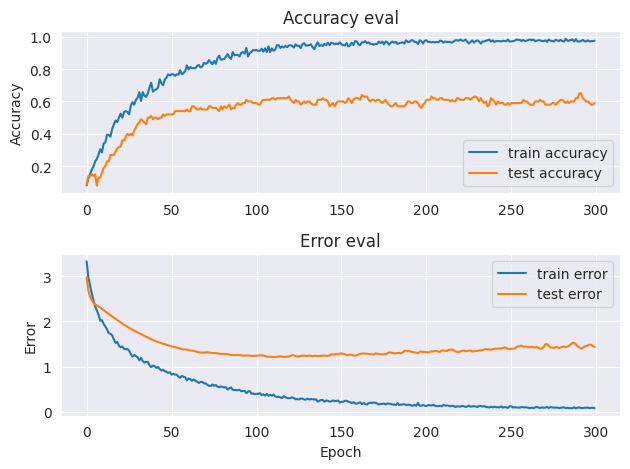

In [32]:
acc_err_plot(cnn_history_mfcc)

# LSTM

In [39]:
def _LSTM_model_compile(_X_train):
  _lstm = Sequential([
    LSTM(64, input_shape=(_X_train.shape[1], _X_train.shape[2]),
         return_sequences=True),
    LSTM(64),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # output
    Dense(len(category_labelling_map), activation='softmax')
  ])

  return _lstm

def _LSTM_(_model, _X_train, _X_test, _y_train, _y_test, _epochs=100):
  _history = _model.fit(_X_train, _y_train,
                        validation_data=(_X_test, _y_test),
                        batch_size=64, epochs=_epochs)
  return _history

In [40]:
# Mel Spectogram
lstm_spect = _LSTM_model_compile(X_train_spect)
lstm_spect.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
lstm_spect.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 17, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                                 
Total params: 87242 (340.79 KB)
Trainable params: 87242 (340.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
lstm_history_spect = _NN_(lstm_spect, X_train_spect, X_test_spect,
                          y_train_spect, y_test_spect, 300)

Epoch 1/300
7/7 [==============================] - 2s 82ms/step - loss: 2.3132 - accuracy: 0.0850 - val_loss: 2.3560 - val_accuracy: 0.0700
Epoch 2/300
7/7 [==============================] - 0s 17ms/step - loss: 2.2939 - accuracy: 0.1125 - val_loss: 2.3490 - val_accuracy: 0.0800
Epoch 3/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2860 - accuracy: 0.1525 - val_loss: 2.3423 - val_accuracy: 0.0800
Epoch 4/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2762 - accuracy: 0.1250 - val_loss: 2.3365 - val_accuracy: 0.0800
Epoch 5/300
7/7 [==============================] - 0s 16ms/step - loss: 2.2649 - accuracy: 0.1500 - val_loss: 2.3308 - val_accuracy: 0.1000
Epoch 6/300
7/7 [==============================] - 0s 17ms/step - loss: 2.2451 - accuracy: 0.1900 - val_loss: 2.3258 - val_accuracy: 0.1000
Epoch 7/300
7/7 [==============================] - 0s 17ms/step - loss: 2.2320 - accuracy: 0.2350 - val_loss: 2.3206 - val_accuracy: 0.1000
Epoch 8/300
7/7 [===

In [42]:
_print_loss_accuracy(lstm_spect, X_test_spect, y_test_spect)

4/4 - 0s - loss: 2.3166 - accuracy: 0.5100 - 26ms/epoch - 6ms/step
Loss: 2.3166420459747314, Accuracy: 0.5099999904632568


In [43]:
# Mel-Frequency Cepstral Coefficients
lstm_mfcc = _LSTM_model_compile(X_train_mfcc)
lstm_mfcc.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
lstm_mfcc.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 17, 64)            21760     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
Total params: 59594 (232.79 KB)
Trainable params: 59594 (232.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
lstm_history_mfcc = _NN_(lstm_mfcc, X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, 300)

Epoch 1/300
7/7 [==============================] - 2s 77ms/step - loss: 2.3282 - accuracy: 0.1050 - val_loss: 2.2916 - val_accuracy: 0.1100
Epoch 2/300
7/7 [==============================] - 0s 16ms/step - loss: 2.3079 - accuracy: 0.1250 - val_loss: 2.2768 - val_accuracy: 0.1100
Epoch 3/300
7/7 [==============================] - 0s 15ms/step - loss: 2.3048 - accuracy: 0.1500 - val_loss: 2.2634 - val_accuracy: 0.1700
Epoch 4/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2678 - accuracy: 0.1725 - val_loss: 2.2505 - val_accuracy: 0.2000
Epoch 5/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2616 - accuracy: 0.1950 - val_loss: 2.2374 - val_accuracy: 0.2000
Epoch 6/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2463 - accuracy: 0.1925 - val_loss: 2.2257 - val_accuracy: 0.2000
Epoch 7/300
7/7 [==============================] - 0s 15ms/step - loss: 2.2319 - accuracy: 0.2250 - val_loss: 2.2138 - val_accuracy: 0.2000
Epoch 8/300
7/7 [===

In [45]:
_print_loss_accuracy(lstm_mfcc, X_test_mfcc, y_test_mfcc)

4/4 - 0s - loss: 2.1135 - accuracy: 0.5900 - 26ms/epoch - 6ms/step
Loss: 2.1135306358337402, Accuracy: 0.5899999737739563


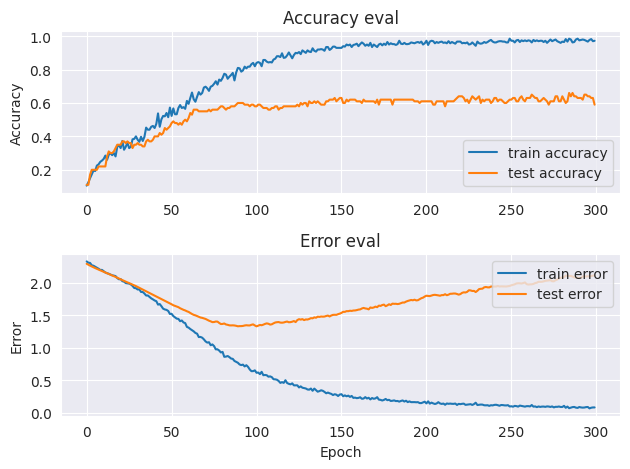

In [46]:
acc_err_plot(lstm_history_mfcc)

## VGG and efficientNetB5

In [49]:
from tensorflow.keras.applications import VGG16, EfficientNetB5
from tensorflow.keras.layers import Input, Concatenate

In [58]:
import tensorflow as tf

In [52]:
X_train_spect.shape

(400, 17, 128, 1)

In [59]:
# Expand dimensions to convert (17, 128, 1) to (17, 128, 3)
X_train_spect_3ch = np.repeat(X_train_spect, 3, axis=-1)
X_test_spect_3ch = np.repeat(X_test_spect, 3, axis=-1)

X_train_mfcc_3ch = np.repeat(X_train_mfcc, 3, axis=-1)
X_test_mfcc_3ch = np.repeat(X_test_mfcc, 3, axis=-1)

# Resize the input to the minimum required size for VGG16/EfficientNetB5
new_height = 32
new_width = 128  # or a different width as necessary

X_train_spect_resized = tf.image.resize(
  X_train_spect_3ch, [new_height, new_width])
X_test_spect_resized = tf.image.resize(
  X_test_spect_3ch, [new_height, new_width])

X_train_mfcc_resized = tf.image.resize(
  X_train_mfcc_3ch, [new_height, new_width])
X_test_mfcc_resized = tf.image.resize(
  X_test_mfcc_3ch, [new_height, new_width])

In [60]:
print(X_train_spect_resized.shape)
print(X_test_spect_resized.shape)
print(X_train_mfcc_resized.shape)
print(X_test_mfcc_resized.shape)

(400, 32, 128, 3)
(100, 32, 128, 3)
(400, 32, 128, 3)
(100, 32, 128, 3)


In [61]:
input_shape_resized = (new_height, new_width, 3)

In [64]:
# Load VGG16 model
vgg_base_model_spect = VGG16(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape_resized)
# vgg_model_spect.trainable = False  # Freeze the layers

vgg_base_model_mfcc = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape_resized)
# vgg_model_mfcc.trainable = False  # Freeze the layers

In [67]:
x_spect = vgg_base_model_spect.output
x_spect = Flatten()(x_spect)
x_spect = Dense(64, activation='relu')(x_spect)
x_spect = Dropout(0.3)(x_spect)
predictions_vgg_spect = Dense(len(category_labelling_map),
                    activation='softmax')(x_spect)

vgg_model_spect = models.Model(inputs=vgg_base_model_spect.input, outputs=predictions_vgg_spect)

vgg_model_spect.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [68]:
x_mfcc = vgg_base_model_mfcc.output
x_mfcc = Flatten()(x_mfcc)
x_mfcc = Dense(64, activation='relu')(x_mfcc)
x_mfcc = Dropout(0.3)(x_mfcc)
predictions_vgg_mfcc = Dense(len(category_labelling_map),
                    activation='softmax')(x_mfcc)

vgg_model_mfcc = models.Model(inputs=vgg_base_model_mfcc.input, outputs=predictions_vgg_mfcc)

vgg_model_mfcc.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [69]:
efnet_base_model_spect = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape_resized)

efnet_base_model_mfcc = EfficientNetB5(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape_resized)

In [70]:
x_spect = efnet_base_model_spect.output
x_spect = Flatten()(x_spect)
x_spect = Dense(64, activation='relu')(x_spect)
x_spect = Dropout(0.3)(x_spect)
predictions_efnet_spect = Dense(len(category_labelling_map),
                    activation='softmax')(x_spect)

effnet_model_spect = models.Model(inputs=efnet_base_model_spect.input, outputs=predictions_efnet_spect)

effnet_model_spect.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [71]:
x_mfcc = efnet_base_model_mfcc.output
x_mfcc = Flatten()(x_mfcc)
x_mfcc = Dense(64, activation='relu')(x_mfcc)
x_mfcc = Dropout(0.3)(x_mfcc)
predictions_efnet_mfcc = Dense(len(category_labelling_map),
                    activation='softmax')(x_mfcc)

effnet_model_mfcc = models.Model(inputs=efnet_base_model_mfcc.input, outputs=predictions_efnet_mfcc)

effnet_model_mfcc.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
# Load EfficientNetB5 model
efficientnet_model_spect = EfficientNetB5(
  weights='imagenet', include_top=False,
  input_shape=X_train_mfcc.shape[1:])
efficientnet_model_spect.trainable = False  # Freeze the layers

efficientnet_model_mfcc = EfficientNetB5(
  weights='imagenet', include_top=False,
  input_shape=X_train_mfcc.shape[1:])
efficientnet_model_mfcc.trainable = False  # Freeze the layers

In [0]:
input_spect_vgg = Input(shape=spectogram_feature.shape[1:])
input_spect_efficientnet = Input(shape=spectogram_feature.shape[1:])

input_mfcc_vgg = Input(shape=spectogram_feature.shape[1:])
input_mfcc_efficientnet = Input(shape=spectogram_feature.shape[1:])

# Flatten the feature maps
flatten_spec_vgg = Flatten()(input_spect_vgg)
flatten_spec_efficientnet = Flatten()(input_spect_efficientnet)
flatten_mfcc_vgg = Flatten()(input_mfcc_vgg)
flatten_mfcc_efficientnet = Flatten()(input_mfcc_efficientnet)

# Concatenate the features
merged_spect = Concatenate()([flatten_spec_vgg, flatten_spec_efficientnet])
merged_mfcc = Concatenate()([flatten_mfcc_vgg, flatten_mfcc_efficientnet])

# Add additional layers
x_spect2 = Dense(256, activation='relu')(merged_spect)
output_spect = Dense(10, activation='softmax')(x_spect2)  # Adjust later if required

x_mfcc2 = Dense(256, activation='relu')(merged_mfcc)
output_mfcc = Dense(10, activation='softmax')(x_mfcc2)  # Adjust later if required

In [0]:
combined_model_spect = models.Model(inputs=[input_spect_vgg, input_spect_efficientnet],
                                    outputs=output_spect)
combined_model_spect.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
combined_model_mfcc = models.Model(inputs=[input_mfcc_vgg, input_mfcc_efficientnet],
                                    outputs=output_mfcc)
combined_model_mfcc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
from tensorflow.keras.layers import TimeDistributed

In [73]:
time_distributed_input_shape = (None, *input_shape_resized)

In [ ]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape_resized)








vgg_base_model_spect = VGG16(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape_resized)
# vgg_model_spect.trainable = False  # Freeze the layers

vgg_base_model_mfcc = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=input_shape_resized)











time_distributed_vgg = TimeDistributed(base_model_vgg, input_shape=time_distributed_input_shape)

lstm_input_shape = (_X_train_resized.shape[1], _X_train_resized.shape[2], _X_train_resized.shape[3])

inputs = Input(shape=lstm_input_shape)

x = time_distributed_vgg(inputs)
x = TimeDistributed(Flatten())(x)

x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(category_labelling_map), activation='softmax')(x)

_lstm_vgg_model = Model(inputs=inputs, outputs=predictions)

_lstm_vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


In [92]:
def build_vgg16(input_shape, num_classes):
  model = Sequential([
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # Classification block
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
  ])

  return model

In [93]:
vgg16_spect_model = build_vgg16(input_shape_resized,
                                      X_train_spect.shape[0])
vgg16_spect_model.compile(optimizer=optimizers.Adam(),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
vgg16_spect_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 128, 64)       1792      
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 128, 64)       36928     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 64, 128)       147584    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 8, 32, 128)        0         
 ng2D)                                               

In [94]:
vgg16_history_spect = _NN_(vgg16_spect_model,
                           X_train_spect_resized,
                           X_test_spect_resized,
                           y_train_spect,
                           y_test_spect, 100)
_print_loss_accuracy(vgg16_spect_model,
                     X_test_spect_resized,
                     y_test_spect)

Epoch 1/100
7/7 [==============================] - 6s 715ms/step - loss: 23.6601 - accuracy: 0.0800 - val_loss: 5.6060 - val_accuracy: 0.0800
Epoch 2/100
7/7 [==============================] - 5s 689ms/step - loss: 4.6040 - accuracy: 0.0925 - val_loss: 3.5964 - val_accuracy: 0.0700
Epoch 3/100
7/7 [==============================] - 5s 701ms/step - loss: 2.9648 - accuracy: 0.1250 - val_loss: 2.6669 - val_accuracy: 0.1300
Epoch 4/100
7/7 [==============================] - 5s 708ms/step - loss: 2.5721 - accuracy: 0.0900 - val_loss: 2.4865 - val_accuracy: 0.0800
Epoch 5/100
7/7 [==============================] - 5s 699ms/step - loss: 2.3650 - accuracy: 0.1100 - val_loss: 2.2593 - val_accuracy: 0.1300
Epoch 6/100
7/7 [==============================] - 5s 696ms/step - loss: 2.3186 - accuracy: 0.1050 - val_loss: 2.2368 - val_accuracy: 0.1300
Epoch 7/100
7/7 [==============================] - 5s 768ms/step - loss: 2.1902 - accuracy: 0.2000 - val_loss: 2.1016 - val_accuracy: 0.2500
Epoch 8/100


In [95]:
vgg16_mfcc_model = build_vgg16(input_shape_resized,
                                      X_train_mfcc.shape[0])
vgg16_mfcc_model.compile(optimizer=optimizers.Adam(),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
vgg16_mfcc_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 32, 128, 64)       1792      
                                                                 
 conv2d_52 (Conv2D)          (None, 32, 128, 64)       36928     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 64, 128)       147584    
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 8, 32, 128)        0         
 ng2D)                                               

In [96]:
vgg16_history_mfcc = _NN_(vgg16_mfcc_model,
                           X_train_mfcc_resized,
                           X_test_mfcc_resized,
                           y_train_mfcc,
                           y_test_mfcc, 100)
_print_loss_accuracy(vgg16_mfcc_model,
                     X_test_mfcc_resized,
                     y_test_mfcc)

Epoch 1/100
7/7 [==============================] - 7s 722ms/step - loss: 12.1948 - accuracy: 0.0675 - val_loss: 5.2477 - val_accuracy: 0.0700
Epoch 2/100
7/7 [==============================] - 5s 721ms/step - loss: 4.8539 - accuracy: 0.1075 - val_loss: 3.0473 - val_accuracy: 0.0700
Epoch 3/100
7/7 [==============================] - 5s 708ms/step - loss: 3.3891 - accuracy: 0.1075 - val_loss: 2.9156 - val_accuracy: 0.0900
Epoch 4/100
7/7 [==============================] - 5s 713ms/step - loss: 2.9534 - accuracy: 0.1150 - val_loss: 2.7266 - val_accuracy: 0.1000
Epoch 5/100
7/7 [==============================] - 5s 709ms/step - loss: 2.6944 - accuracy: 0.1000 - val_loss: 2.4909 - val_accuracy: 0.1000
Epoch 6/100
7/7 [==============================] - 5s 730ms/step - loss: 2.4060 - accuracy: 0.0950 - val_loss: 2.4446 - val_accuracy: 0.0600
Epoch 7/100
7/7 [==============================] - 5s 709ms/step - loss: 2.3605 - accuracy: 0.1075 - val_loss: 2.3086 - val_accuracy: 0.1000
Epoch 8/100


In [99]:
def build_effnetb5(input_shape, num_classes=400):
  base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=input_shape)
  base_model.trainable = False  # Freeze the base model

  model = models.Sequential()
  model.add(base_model)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

In [100]:
effnetb5_spect_model = build_effnetb5(input_shape_resized,
                                      X_train_spect.shape[0])
effnetb5_spect_model.compile(optimizer=optimizers.Adam(),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
effnetb5_spect_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 1, 4, 2048)        28513527  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_43 (Dense)            (None, 400)               819600    
                                                                 
Total params: 29333127 (111.90 MB)
Trainable params: 819600 (3.13 MB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


In [101]:
efnet_history_spect = _NN_(effnetb5_spect_model,
                           X_train_spect_resized,
                           X_test_spect_resized,
                           y_train_spect,
                           y_test_spect, 100)

Epoch 1/100
7/7 [==============================] - 10s 667ms/step - loss: 4.1658 - accuracy: 0.0750 - val_loss: 2.3996 - val_accuracy: 0.1200
Epoch 2/100
7/7 [==============================] - 2s 366ms/step - loss: 2.3492 - accuracy: 0.1450 - val_loss: 2.2756 - val_accuracy: 0.1700
Epoch 3/100
7/7 [==============================] - 3s 371ms/step - loss: 2.2456 - accuracy: 0.1525 - val_loss: 2.2442 - val_accuracy: 0.1100
Epoch 4/100
7/7 [==============================] - 2s 352ms/step - loss: 2.2208 - accuracy: 0.1600 - val_loss: 2.2223 - val_accuracy: 0.2400
Epoch 5/100
7/7 [==============================] - 2s 363ms/step - loss: 2.2013 - accuracy: 0.1525 - val_loss: 2.1851 - val_accuracy: 0.2100
Epoch 6/100
7/7 [==============================] - 3s 373ms/step - loss: 2.1668 - accuracy: 0.1825 - val_loss: 2.1330 - val_accuracy: 0.2200
Epoch 7/100
7/7 [==============================] - 2s 367ms/step - loss: 2.1497 - accuracy: 0.2175 - val_loss: 2.1551 - val_accuracy: 0.2000
Epoch 8/100


AttributeError: 'History' object has no attribute 'evaluate'

In [102]:
_print_loss_accuracy(effnetb5_spect_model,
                     X_test_spect_resized,
                     y_test_spect)

4/4 - 1s - loss: 1.7529 - accuracy: 0.4100 - 1s/epoch - 254ms/step
Loss: 1.7529296875, Accuracy: 0.4099999964237213


In [104]:
effnetb5_mfcc_model = build_effnetb5(input_shape_resized,
                                      X_train_mfcc.shape[0])
effnetb5_mfcc_model.compile(optimizer=optimizers.Adam(),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
effnetb5_mfcc_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 1, 4, 2048)        28513527  
 )                                                               
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 400)               819600    
                                                                 
Total params: 29333127 (111.90 MB)
Trainable params: 819600 (3.13 MB)
Non-trainable params: 28513527 (108.77 MB)
_________________________________________________________________


In [105]:

effnet_history_mfcc = _NN_(effnetb5_mfcc_model,
                           X_train_mfcc_resized,
                           X_test_mfcc_resized,
                           y_train_mfcc,
                           y_test_mfcc, 100)
_print_loss_accuracy(effnetb5_mfcc_model,
                     X_test_mfcc_resized,
                     y_test_mfcc)

Epoch 1/100
7/7 [==============================] - 9s 571ms/step - loss: 4.2182 - accuracy: 0.0800 - val_loss: 2.4151 - val_accuracy: 0.1500
Epoch 2/100
7/7 [==============================] - 2s 366ms/step - loss: 2.3825 - accuracy: 0.1300 - val_loss: 2.2640 - val_accuracy: 0.1900
Epoch 3/100
7/7 [==============================] - 2s 364ms/step - loss: 2.3156 - accuracy: 0.1400 - val_loss: 2.2344 - val_accuracy: 0.0900
Epoch 4/100
7/7 [==============================] - 2s 362ms/step - loss: 2.2255 - accuracy: 0.1850 - val_loss: 2.1670 - val_accuracy: 0.2000
Epoch 5/100
7/7 [==============================] - 2s 363ms/step - loss: 2.1964 - accuracy: 0.1900 - val_loss: 2.1450 - val_accuracy: 0.2500
Epoch 6/100
7/7 [==============================] - 2s 366ms/step - loss: 2.1753 - accuracy: 0.1725 - val_loss: 2.1906 - val_accuracy: 0.2300
Epoch 7/100
7/7 [==============================] - 2s 366ms/step - loss: 2.1589 - accuracy: 0.2325 - val_loss: 2.0766 - val_accuracy: 0.3700
Epoch 8/100
7

In [85]:
np.array(X_train_spect_resized).shape

(400, 32, 128, 3)

In [88]:
input_shape_resized

(32, 128, 3)

In [91]:
efnet_history_spect = _NN_(effnetb5_spect_model,
                           np.array(X_train_spect_resized),
                           np.array(X_test_spect_resized),
                           y_train_spect,
                           y_test_spect, 100)


Epoch 1/100
7/7 [==============================] - 9s 569ms/step - loss: 4.1727 - accuracy: 0.0700 - val_loss: 2.4395 - val_accuracy: 0.1000
Epoch 2/100
7/7 [==============================] - 3s 372ms/step - loss: 2.3701 - accuracy: 0.1275 - val_loss: 2.2813 - val_accuracy: 0.1300
Epoch 3/100
7/7 [==============================] - 3s 372ms/step - loss: 2.3209 - accuracy: 0.1325 - val_loss: 2.2725 - val_accuracy: 0.1100
Epoch 4/100
7/7 [==============================] - 2s 363ms/step - loss: 2.2151 - accuracy: 0.1825 - val_loss: 2.2104 - val_accuracy: 0.2000
Epoch 5/100
7/7 [==============================] - 3s 369ms/step - loss: 2.2147 - accuracy: 0.1825 - val_loss: 2.1659 - val_accuracy: 0.2200
Epoch 6/100
7/7 [==============================] - 3s 394ms/step - loss: 2.1506 - accuracy: 0.2375 - val_loss: 2.1721 - val_accuracy: 0.2200
Epoch 7/100
7/7 [==============================] - 3s 380ms/step - loss: 2.1364 - accuracy: 0.2250 - val_loss: 2.1187 - val_accuracy: 0.3100
Epoch 8/100
7

## Prediction by CNN (87%)

In [47]:
def prediction_by_model(model):
  rnd_test_index = random.randint(0, len(X_test_2_mfcc))

  x_to_predict = X_test_2_mfcc[rnd_test_index]
  y_to_predict = y_test_2_mfcc[rnd_test_index]
  
  # add 1 dimension to input data for sample - model.predict() expects a 4d array in this case
  x_to_predict = x_to_predict[np.newaxis, ...]
  
  prediction = model.predict(x_to_predict)
  
  predicted_index = np.argmax(prediction, axis=1)
  
  print(f"Target: {find_category(y_to_predict)}, Predicted label: {find_category(predicted_index)}; test index: {rnd_test_index}")

In [48]:
prediction_by_model(cnn_mfcc)

NameError: name 'X_test_2_mfcc' is not defined

In [119]:
prediction_by_model(cnn_mfcc)

1/1 [==============================] - 0s 16ms/step
Target: Police, Predicted label: Police; test index: 25


In [136]:
prediction_by_model(cnn_mfcc)

1/1 [==============================] - 0s 15ms/step
Target: Engine, Predicted label: Engine; test index: 85


# Performance metrics (Best from each algorithms)

In [141]:
def get_performance_metrics(_model, _X_test, _y_test, _prediction=None):
  if _prediction is None:
    _y_pred = _model.predict(_X_test)
    _prediction = np.argmax(_y_pred, axis=1)
  
  _accuracy = accuracy_score(_y_test, _prediction)
  _precision = precision_score(_y_test, _prediction, average='weighted')
  _recall = recall_score(_y_test, _prediction, average='weighted')
  _f1 = f1_score(_y_test, _prediction, average='weighted')
  _conf_matx = confusion_matrix(_y_test, _prediction)
  
  print(f"Accuracy: {_accuracy}")
  print(f"Precision: {_precision}")
  print(f"Recall: {_recall}")
  print(f"F1 Score: {_f1}")
  
  return _accuracy, _precision, _recall, _f1, _conf_matx

In [145]:
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_conf_matx = get_performance_metrics(
  None, X_test_1_mfcc, y_test_1_mfcc, svm_predictions_mfcc 
)

Accuracy: 0.59
Precision: 0.619974358974359
Recall: 0.59
F1 Score: 0.5917658569500674


In [146]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_conf_matx = get_performance_metrics(
  None, X_test_1_mfcc, y_test_1_mfcc, lr_predictions_mfcc 
)

Accuracy: 0.54
Precision: 0.5780194805194806
Recall: 0.54
F1 Score: 0.5493635477582846


In [147]:
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_conf_matx = get_performance_metrics(
  None, X_test_1_spect, y_test_1_spect, dt_predictions_spect 
)

Accuracy: 0.57
Precision: 0.5796017316017317
Recall: 0.57
F1 Score: 0.5618878089873514


In [142]:
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_conf_matx = get_performance_metrics(
  cnn_mfcc, X_test_2_mfcc, y_test_2_mfcc
)

4/4 [==============================] - 0s 5ms/step
Accuracy: 0.87
Precision: 0.8746536796536796
Recall: 0.87
F1 Score: 0.8696137566137565


In [143]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_conf_matx = get_performance_metrics(
  lstm_mfcc, X_test_2_mfcc, y_test_2_mfcc
)

4/4 [==============================] - 0s 6ms/step
Accuracy: 0.83
Precision: 0.8281060606060606
Recall: 0.83
F1 Score: 0.8244920634920635


## Performance metrics graph

In [148]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
performance_metrics = {
  'SVM': [svm_accuracy, svm_precision, svm_recall, svm_f1],
  'LR': [lr_accuracy, lr_precision, lr_recall, lr_f1],
  'DT': [dt_accuracy, dt_precision, dt_recall, dt_f1],
  'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1],
  'LSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1],
}
performance_metrics

{'SVM': [0.59, 0.619974358974359, 0.59, 0.5917658569500674],
 'LR': [0.54, 0.5780194805194806, 0.54, 0.5493635477582846],
 'DT': [0.57, 0.5796017316017317, 0.57, 0.5618878089873514],
 'CNN': [0.87, 0.8746536796536796, 0.87, 0.8696137566137565],
 'LSTM': [0.83, 0.8281060606060606, 0.83, 0.8244920634920635]}

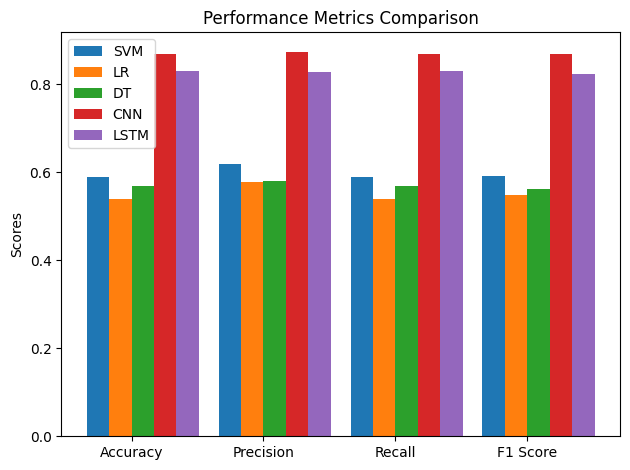

In [149]:
x = np.arange(4)  # total performance metrics
width = 0.17

fig, ax = plt.subplots()

for i, name in enumerate(["SVM", "LR", "DT", "CNN", "LSTM"]):
    ax.bar(x + width*i, performance_metrics[name], width, label=name)

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Confusion matrix

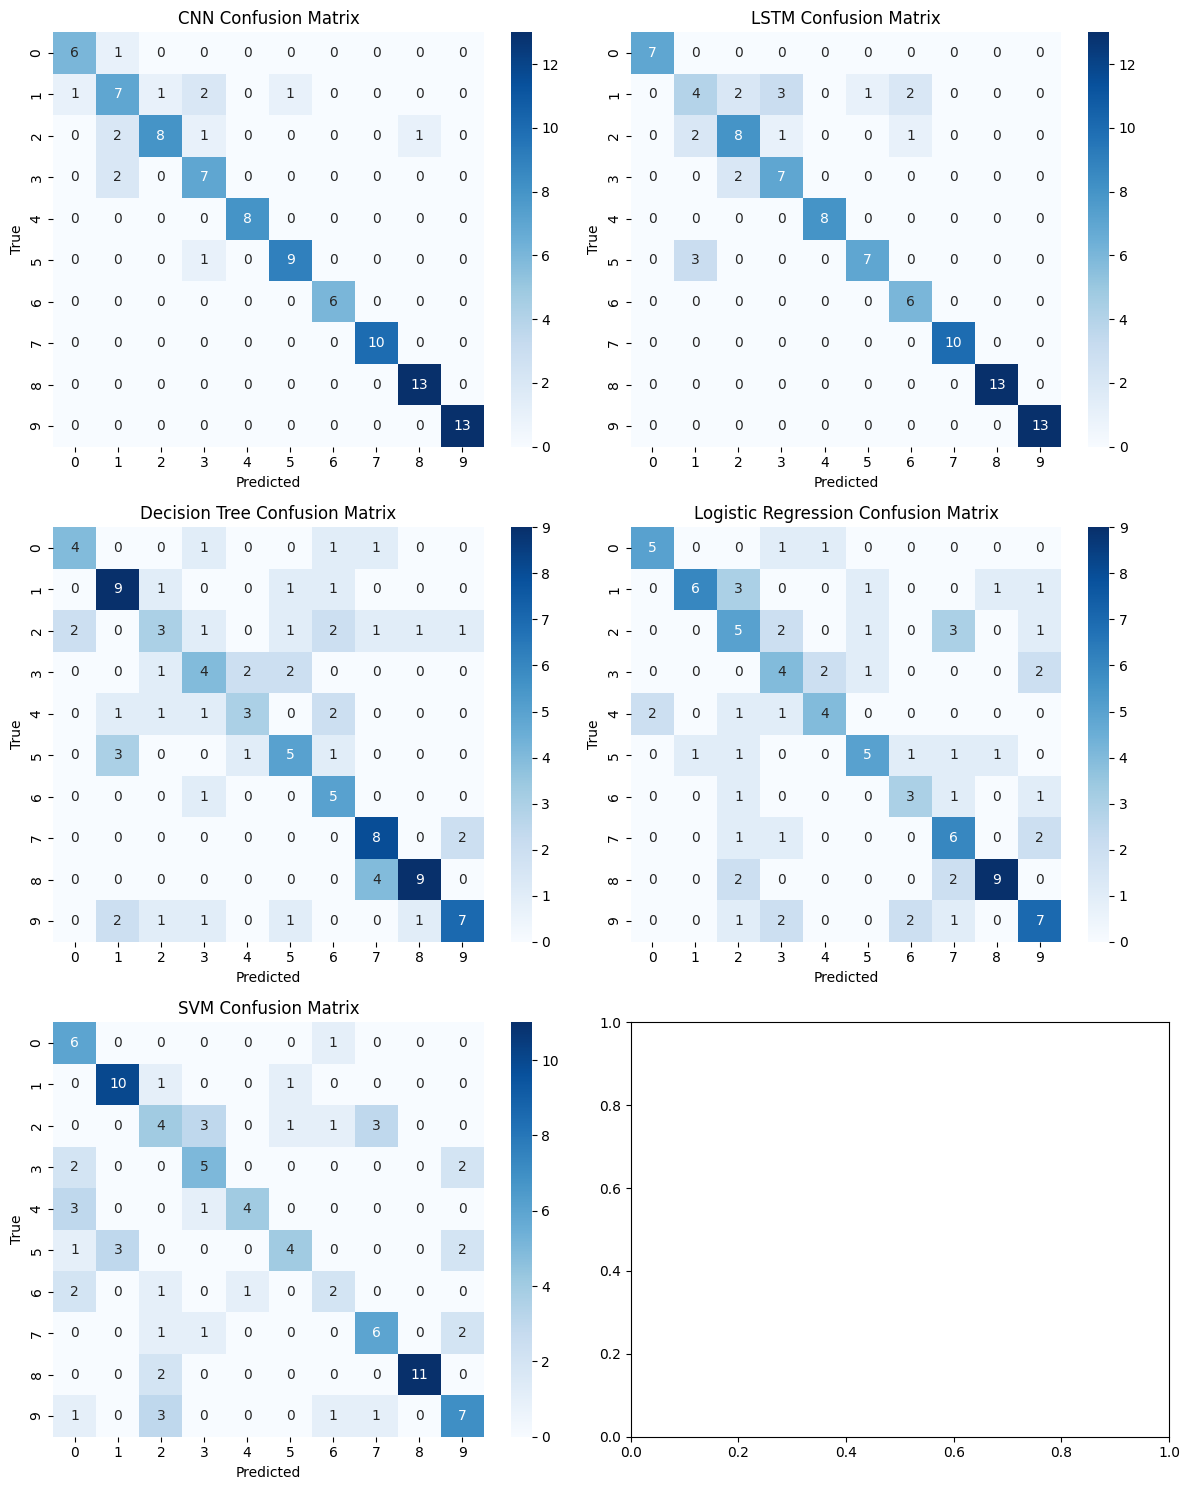

In [151]:
def plot_confusion_matrix(conf_mat, title, ax):
  sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
  ax.set_title(title + ' Confusion Matrix')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

plot_confusion_matrix(cnn_conf_matx, 'CNN', axes[0, 0])
plot_confusion_matrix(lstm_conf_matx, 'LSTM', axes[0, 1])
plot_confusion_matrix(dt_conf_matx, 'Decision Tree', axes[1, 0])
plot_confusion_matrix(lr_conf_matx, 'Logistic Regression', axes[1, 1])
plot_confusion_matrix(svm_conf_matx, 'SVM', axes[2, 0])

plt.tight_layout()
plt.show()
plt.close()

In [163]:
def calculate_metrics(conf_matrix):
  num_classes = len(conf_matrix)
  _metrics = {'TP': [0] * num_classes, 'TN': [0] * num_classes, 'FP': [0] * num_classes, 'FN': [0] * num_classes}
  
  for i in range(num_classes):
    _metrics['TP'][i] = conf_matrix[i, i]
    _metrics['TN'][i] = (np.sum(conf_matrix) - np.sum(conf_matrix[i, :])
                         - np.sum(conf_matrix[:, i]) + conf_matrix[i, i])
    _metrics['FP'][i] = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    _metrics['FN'][i] = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    
  for i2 in range(i+1):
      print(f"Class {i2+1}: TP={_metrics['TP'][i2]}, TN={_metrics['TN'][i2]}, FP={_metrics['FP'][i2]}, FN={_metrics['FN'][i2]}")

for alg in [svm_conf_matx, lr_conf_matx, dt_conf_matx, cnn_conf_matx, lstm_conf_matx]:
  calculate_metrics(alg)
  print("-"*20)

Class 1: TP=6, TN=84, FP=9, FN=1
Class 2: TP=10, TN=85, FP=3, FN=2
Class 3: TP=4, TN=80, FP=8, FN=8
Class 4: TP=5, TN=86, FP=5, FN=4
Class 5: TP=4, TN=91, FP=1, FN=4
Class 6: TP=4, TN=88, FP=2, FN=6
Class 7: TP=2, TN=91, FP=3, FN=4
Class 8: TP=6, TN=86, FP=4, FN=4
Class 9: TP=11, TN=87, FP=0, FN=2
Class 10: TP=7, TN=81, FP=6, FN=6
--------------------
Class 1: TP=5, TN=91, FP=2, FN=2
Class 2: TP=6, TN=87, FP=1, FN=6
Class 3: TP=5, TN=78, FP=10, FN=7
Class 4: TP=4, TN=84, FP=7, FN=5
Class 5: TP=4, TN=89, FP=3, FN=4
Class 6: TP=5, TN=87, FP=3, FN=5
Class 7: TP=3, TN=91, FP=3, FN=3
Class 8: TP=6, TN=82, FP=8, FN=4
Class 9: TP=9, TN=85, FP=2, FN=4
Class 10: TP=7, TN=80, FP=7, FN=6
--------------------
Class 1: TP=4, TN=91, FP=2, FN=3
Class 2: TP=9, TN=82, FP=6, FN=3
Class 3: TP=3, TN=84, FP=4, FN=9
Class 4: TP=4, TN=86, FP=5, FN=5
Class 5: TP=3, TN=89, FP=3, FN=5
Class 6: TP=5, TN=85, FP=5, FN=5
Class 7: TP=5, TN=87, FP=7, FN=1
Class 8: TP=8, TN=84, FP=6, FN=2
Class 9: TP=9, TN=85, FP=2, F